In [1]:
from sea_breeze import load_model_data, sea_breeze_funcs, utils, sea_breeze_filters
import metpy.calc as mpcalc
from dask.distributed import Client
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np


In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42059 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:46083' processes=7 threads=7, memory=32.00 GiB>

In [3]:
t1="2016-01-02 04:00"
t2="2016-01-02 04:00"
lat_slice,lon_slice = utils.get_aus_bounds()
time_slice = slice(t1,t2)


tas = load_model_data.load_aus2200_variable(
    "ta",
    time_slice.start,
    time_slice.stop,
    "mjo-elnino2016",
    lon_slice,
    lat_slice,
    "1hr",
    hgt_slice=slice(0,10),
    chunks={"time":1,"lat":-1,"lon":-1},
    smooth=True,
    sigma=4).sel(lev=5) 
hus = load_model_data.load_aus2200_variable(
    "hus",
    time_slice.start,
    time_slice.stop,
    "mjo-elnino2016",
    lon_slice,
    lat_slice,
    "1hr",
    hgt_slice=slice(0,10),
    chunks={"time":1,"lat":-1,"lon":-1},
    smooth=True,
    sigma=4).sel(lev=5) 
pfull = load_model_data.load_aus2200_variable(
    "pfull",
    time_slice.start,
    time_slice.stop,
    "mjo-elnino2016",
    lon_slice,
    lat_slice,
    "1hr",
    hgt_slice=slice(0,10),
    chunks={"time":1,"lat":-1,"lon":-1},
    sigma=4,
    smooth=True).sel(lev=5)         
uas = load_model_data.load_aus2200_variable(
    "uas",
    time_slice.start,
    time_slice.stop,
    "mjo-elnino2016",
    lon_slice,
    lat_slice,
    "10min",
    staggered="lon",
    chunks={"time":1,"lat":-1,"lon":-1},
    smooth=True,
    sigma=4)        
vas = load_model_data.load_aus2200_variable(
    "vas",
    time_slice.start,
    time_slice.stop,
    "mjo-elnino2016",
    lon_slice,lat_slice,
    "10min",
    staggered="lat",
    chunks={"time":1,"lat":-1,"lon":-1},
    smooth=True,
    sigma=4)

vas = vas.sel(time=vas.time.dt.minute==0)
uas = uas.sel(time=uas.time.dt.minute==0)

In [4]:
dp = mpcalc.dewpoint_from_specific_humidity(pfull,tas,hus)

In [5]:
F_theta = sea_breeze_funcs.kinematic_frontogenesis(
    mpcalc.potential_temperature(pfull,tas) / 1000,
    uas,
    vas).persist()
F_thetae = sea_breeze_funcs.kinematic_frontogenesis(
    mpcalc.equivalent_potential_temperature(pfull,tas,dp) / 1000,
    uas,
    vas).persist()
F_q = sea_breeze_funcs.kinematic_frontogenesis(
    hus,
    uas,
    vas).persist()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 76.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 76.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec

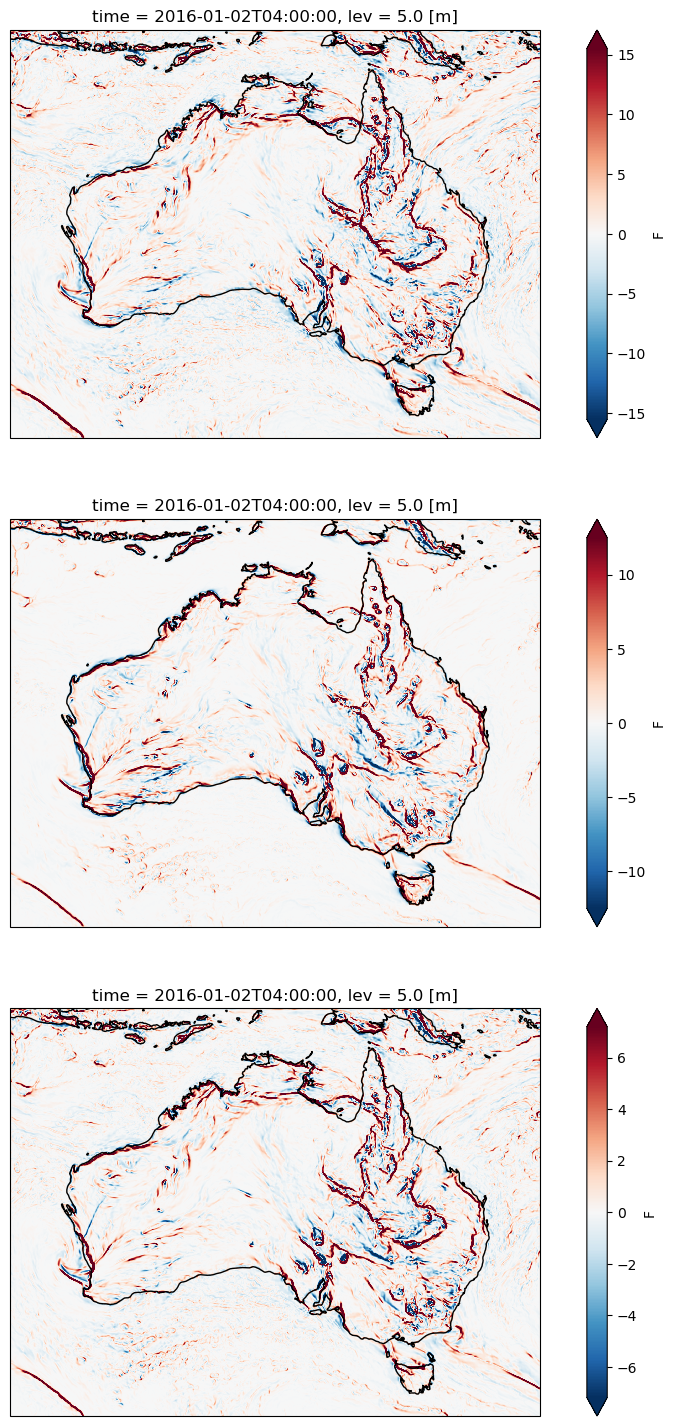

In [6]:
plt.figure(figsize=[12,18])

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree())
F_thetae.F.plot(robust=True)
ax.coastlines()

ax = plt.subplot(3,1,2,projection=ccrs.PlateCarree())
F_theta.F.plot(robust=True)
ax.coastlines()

ax = plt.subplot(3,1,3,projection=ccrs.PlateCarree())
F_q.F.plot(robust=True)
ax.coastlines()



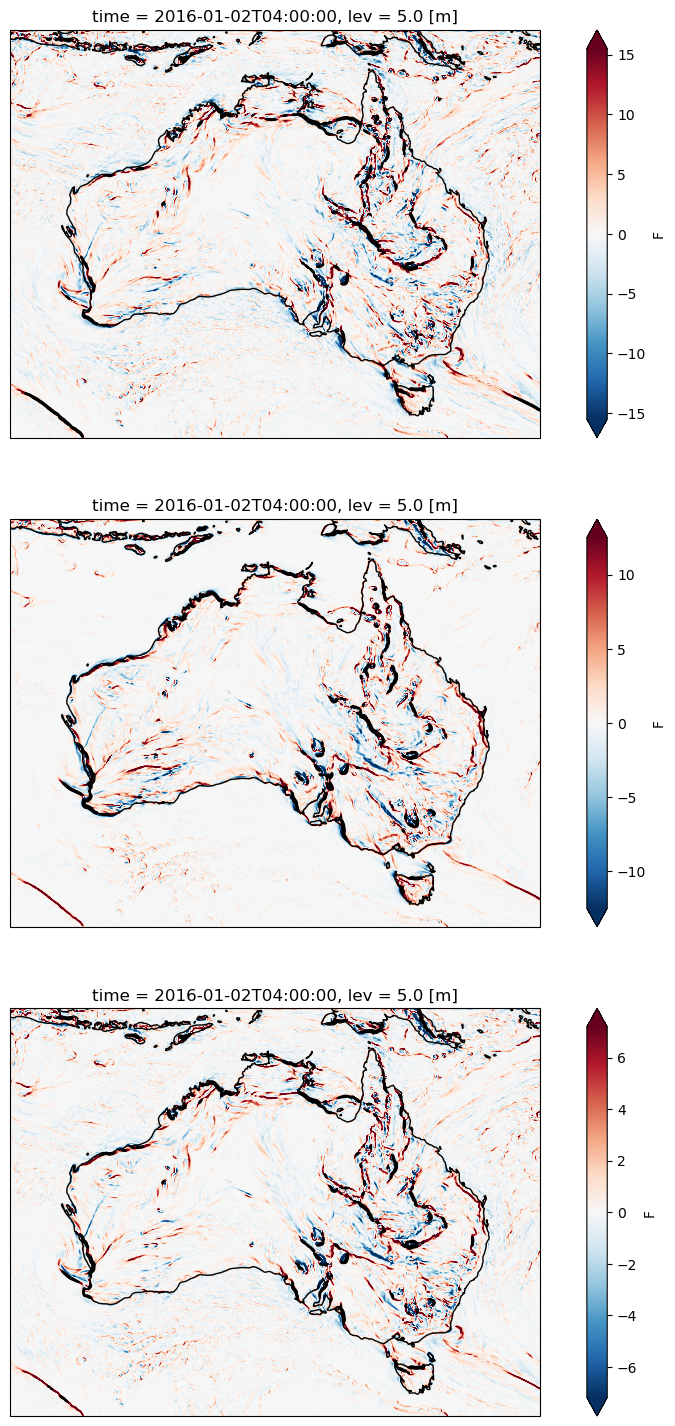

In [7]:
plt.figure(figsize=[12,18])

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree())
F_thetae.F.plot(robust=True)
xr.plot.contour((F_thetae.F >= np.array(sea_breeze_filters.percentile(F_thetae.F))[0]).squeeze(), levels=1, colors="k")
ax.coastlines()

ax = plt.subplot(3,1,2,projection=ccrs.PlateCarree())
F_theta.F.plot(robust=True)
xr.plot.contour((F_theta.F >= np.array(sea_breeze_filters.percentile(F_theta.F))[0]).squeeze(), levels=1, colors="k")
ax.coastlines()

ax = plt.subplot(3,1,3,projection=ccrs.PlateCarree())
F_q.F.plot(robust=True)
xr.plot.contour((F_q.F >= np.array(sea_breeze_filters.percentile(F_q.F))[0]).squeeze(), levels=1, colors="k")
ax.coastlines()

In [15]:
f = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/aus2200_smooth_s4/filters/filtered_mask_percentile3_F_201601010000_201601102300.zarr/")

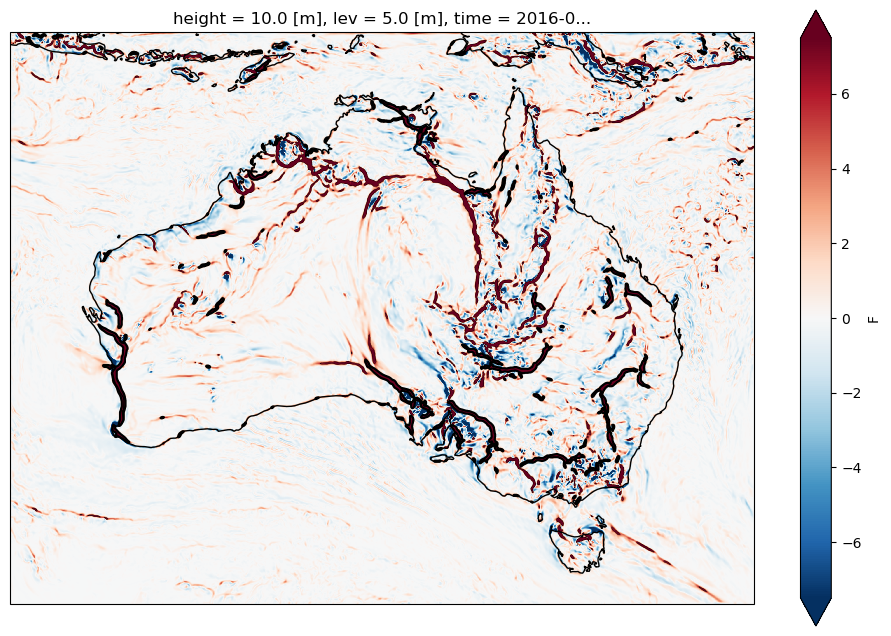

In [25]:
plt.figure(figsize=[12,8])

ax = plt.axes(projection=ccrs.PlateCarree())
F_q.F.plot(robust=True)
#xr.plot.contour(F_q.F.squeeze() >= 5.72, levels=1, colors="k")
xr.plot.contour((f.all_labels.sel(time=t1)>=1),levels=1,linewidths=0.3,colors="k")
xr.plot.contour((f.mask.sel(time=t1)),levels=1,colors="k")
ax.coastlines()

In [44]:
from sea_breeze.load_model_data import *

u = uas
v = vas
q = hus

#Calculate grid spacing in km using metpy, in x and y
x, y = np.meshgrid(q.lon,q.lat)
dx, dy = mpcalc.lat_lon_grid_deltas(x,y)

#Convert the x and y grid spacing arrays into xarray datasets. Need to interpolate to match the original grid
dx = xr.DataArray(np.array(dx),dims=["lat","lon"],coords={"lat":q.lat.values, "lon":q.lon.values[0:-1]}).\
        interp({"lon":q.lon,"lat":q.lat},method="linear",kwargs={"fill_value":"extrapolate"}).\
        chunk({"lat":q.chunksizes["lat"][0], "lon":q.chunksizes["lon"][0]})
dy = xr.DataArray(np.array(dy),dims=["lat","lon"],coords={"lat":q.lat.values[0:-1], "lon":q.lon.values}).\
        interp({"lon":q.lon,"lat":q.lat},method="linear",kwargs={"fill_value":"extrapolate"}).\
        chunk({"lat":q.chunksizes["lat"][0], "lon":q.chunksizes["lon"][0]})

ddy_u = (xr.DataArray(da.gradient(u,axis=q.get_axis_num("lat")), dims=q.dims, coords=q.coords) / dy)
ddx_u = (xr.DataArray(da.gradient(u,axis=q.get_axis_num("lon")), dims=q.dims, coords=q.coords) / dx)
ddy_v = (xr.DataArray(da.gradient(v,axis=q.get_axis_num("lat")), dims=q.dims, coords=q.coords) / dy)
ddx_v = (xr.DataArray(da.gradient(v,axis=q.get_axis_num("lon")), dims=q.dims, coords=q.coords) / dx)
div = ddx_u + ddy_v

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 76.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


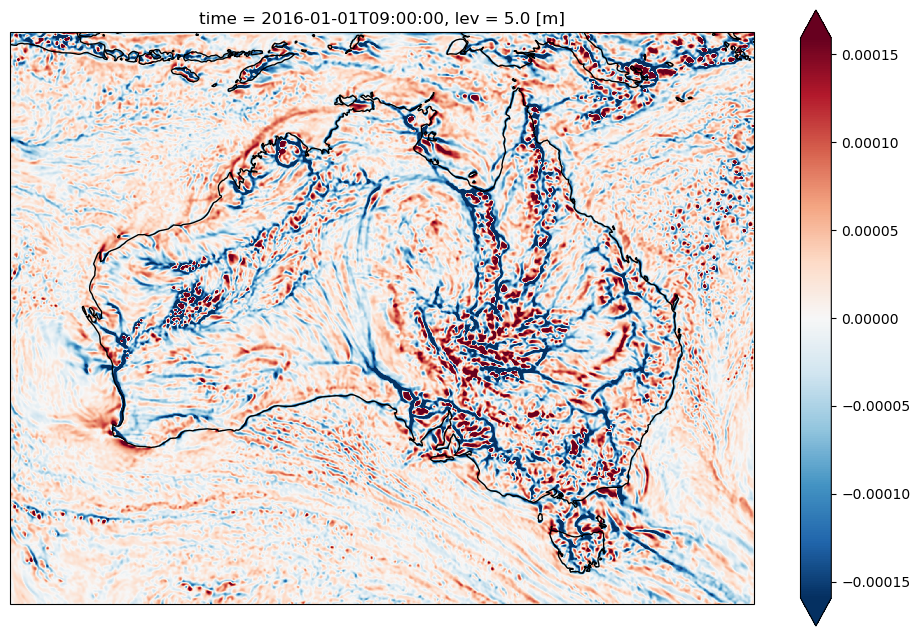

In [45]:
plt.figure(figsize=[12,8])

ax = plt.axes(projection=ccrs.PlateCarree())
div.plot(robust=True)
ax.coastlines()